# Imports

In [1]:
import math
import random
import warnings
from tqdm import tqdm
from itertools import count
from collections import namedtuple, deque

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import gymnasium as gym
from gym.wrappers import TimeLimit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

warnings.simplefilter("ignore", category=DeprecationWarning)
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# Replay Buffer

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Constants

In [3]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
num_episodes = 600

# Greedy Action Selection

In [4]:
def select_action(action_space, state, policy_net, steps_done): 
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[action_space.sample()]], device=device, dtype=torch.long)

# Plotting

In [5]:
def plot_durations(episode_durations, show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# Optimizer

In [6]:
def optimize_model(optimizer, policy_net, target_net, memory):
    
    if len(memory) < BATCH_SIZE:
        return
 
    # [
    #     Transition(
    #         state=tensor([[-0.0632, -0.9992,  0.0976,  1.4934]]), 
    #         action=tensor([[0]]), 
    #         next_state=tensor([[-0.0831, -1.1954,  0.1274,  1.8149]]), 
    #         reward=tensor([1.])),
    #     Transition(
    #         state=tensor([[ 0.0228, -0.1853,  0.0443,  0.3158]]),
    #         action=tensor([[1]]),
    #         next_state=tensor([[0.0191, 0.0092, 0.0506, 0.0374]]),
    #         reward=tensor([1.])),
    #     Transition(
    #         state=tensor([[ 0.1077, -0.7645, -0.0625,  1.0608]]),
    #         action=tensor([[0]]),
    #         next_state=tensor([[ 0.0924, -0.9587, -0.0413,  1.3332]]),
    #         reward=tensor([1.]))
    # ]
    transitions = memory.sample(BATCH_SIZE) # (batch, Transition())

    # Transition(
    #     state=(tensor([[ 0.1416,  0.9714, -0.1053, -1.3007]]), 
    #            tensor([[ 0.0404,  0.5806, -0.0825, -0.9449]]), 
    #            tensor([[ 0.1183,  1.1655, -0.0739, -1.5695]])), 
    #     action=(tensor([[0]]), 
    #             tensor([[0]]), 
    #             tensor([[0]])), 
    #     next_state=(tensor([[ 0.1610,  0.7777, -0.1313, -1.0428]]),
    #                 tensor([[ 0.0520,  0.3867, -0.1014, -0.6793]]),
    #                 tensor([[ 0.1416,  0.9714, -0.1053, -1.3007]])), 
    #     reward=(tensor([1.]), 
    #             tensor([1.]), 
    #             tensor([1.]))
    # )
    batch = Transition(*zip(*transitions)) # Transition((batch,), (batch,), (batch,), (batch,))

    # tensor([True, True, True])
    is_next_states_batch = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool) # (batch,)

    # tensor([[-0.0600, -0.9983,  0.0744,  1.5364],
        # [-0.0340, -0.2066, -0.0314,  0.2412],
        # [-0.0540, -0.4244,  0.0198,  0.6019]]
    # )
    next_states_batch = torch.cat([s for s in batch.next_state if s is not None]) # (batch, 4)

    # tensor([[-1.2915e-01, -2.3612e-01,  6.0752e-02,  3.2493e-01],
    #     [ 1.5827e-01,  8.0256e-01, -1.9460e-01, -1.3580e+00],
    #     [-1.2387e-03,  2.1060e-01,  4.4813e-02, -3.1255e-01]]
    # )
    state_batch = torch.cat(batch.state) # (batch, 4)

    # tensor([[1],
    #     [0],
    #     [0]]
    # )
    action_batch = torch.cat(batch.action) # (batch, 1)

    # tensor([1., 1., 1.])
    reward_batch = torch.cat(batch.reward) # (batch,)
    
    # policy_net finds the 'Q values' for each 'Action in the state'
    # gather returns the Q value for the action that was 'Actually taken'
    state_action_values = policy_net(state_batch).gather(1, action_batch) # (batch, 1)

    # argmax-a[Q(s', a)]
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[is_next_states_batch] = target_net(next_states_batch).max(1).values # (batch,)

    # Compute the expected Q values
    expected_state_action_values = reward_batch + (next_state_values * GAMMA) # (batch,)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1)) # (batch, 1)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Deep Q-Network

In [7]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        
        hidden_sizes = [256, 128, 64]
        layers = []
        
        layers.append(nn.Linear(n_observations, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_sizes[-1], n_actions))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Training

Training Progress: Mean Duration=290: 100%|██████████| 600/600 [10:35<00:00,  1.06s/it]


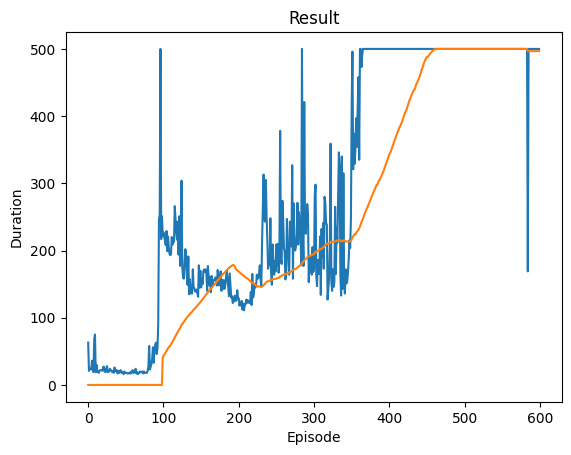

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
env = gym.make("CartPole-v1")
env.unwrapped.theta_threshold_radians = np.deg2rad(45)
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(500)

episode_durations = []
running_mean = 0
episode_count = 0
steps_done = 0

progress_bar = tqdm(range(num_episodes), desc="Training Progress: Mean Duration=0.00")

for i_episode in progress_bar:
    state, info = env.reset()

    # (1, 4)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        # (1, 1)
        action = select_action(env.action_space, state, policy_net, steps_done)
        steps_done += 1
        
        # (4,)       1.0     False       False
        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        # (1)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            # (1, 4)
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        # state (1, 4):  tensor([[-0.0055,  0.0394,  0.0167, -0.0443]]) 
        # action (1, 1):  tensor([[0]])
        # next_state (1, 4):  tensor([[-0.0047, -0.1559,  0.0158,  0.2536]])
        # reward (1):  tensor([1.])

        #          (1, 4), (1, 1), (1, 4),     (1)
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model(optimizer, policy_net, target_net, memory)
        
        # Soft update of the target network's weights     
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_count += 1
            running_mean = running_mean + (episode_durations[-1] - running_mean) / episode_count
            break
            
    progress_bar.set_description(f"Training Progress: Mean Duration={running_mean:.0f}")

plot_durations(episode_durations, True)
plt.ioff()
plt.show()

In [13]:
env = gym.make("CartPole-v1")
env = TimeLimit(env, max_episode_steps=500)
test_iterations = []

for i in range(10):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = policy_net(state).max(1).indices.view(1, 1)
        observation, reward, terminated, truncated = env.step(action.item())
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        if terminated:
            test_iterations.append(t)
            break

env.close()
print('Mean steps: ', np.mean(test_iterations))

Mean steps:  499.0


In [14]:
torch.save(policy_net.state_dict(), "cartpole_policy.pth")